In [1]:
# styling
from IPython import utils  
from IPython.core.display import HTML  
import os  
def css_styling():  
    """Load default custom.css file from ipython profile"""
    base = utils.path.get_ipython_dir()
    styles = "<style>\n%s\n</style>" % (open(os.path.join(base,'profile_default/static/custom/custom.css'),'r').read())
    return HTML(styles)
css_styling()  

C:\Users\nolefp\AppData\Roaming\Python\Python27\site-packages\IPython\utils\path.py:258: UserWarning: get_ipython_dir has moved to the IPython.paths module
  warn("get_ipython_dir has moved to the IPython.paths module")


In [2]:
%matplotlib inline

C:\Users\nolefp\Anaconda\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
# libraries + pandas options
import numpy as np
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels import discrete
import re
import regex
import collections
import pandas as pd
import math 
import csv
import time
import dateutil
from datetime import datetime
import seaborn as sns
import json

pd.set_option('display.width', 1500)
pd.set_option('max_colwidth',100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.options.display.float_format = '{:,.5f}'.format
sns.set_style("whitegrid")
sns.set_context("poster")

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import ticker
    

In [4]:
# EventRegistry login
from eventregistry import *
er = EventRegistry()
er.login("rradovanovic@college.harvard.edu","ruski.EVENT1")

Event Registry host: http://eventregistry.org


{u'action': u'success', u'desc': u'Login successful'}

# Notebook Contents

[Selecting Firms](#firms)

[Obtaining Firms Data & Financials](#financials)

[Get company concepts](#concepts)
  * [Get list of company names](#comnam)
  * [Testing getConceptUri](#getconcept)      
  * [Ticker-name dictionary](#namesdict)
  * [Testing suggestConcepts](#suggestconcepts)
  * [Exploring concept info](#conceptinfo)
  * [Ticker-uri dictionary](#ticdict)

[Querying News](#news)
  * [Articles](#articles)
  * [Events](#events)
  
[News Cosines](#newscosines)

[Calculating Market Correlations](#marketcorr)

[Comparing Results](#results)

# Selecting Firms <a id='firms'></a>

Similar to Yaros & Imielinski(Y&I, 2015), in this paper I use firms from the S&P 500, 400, and 600. To obtain the constituents of these indexes I query COMPUSTAT's monthly index constituents database for the time range 2014-2016, as this is the period for which Event Registry has news data. It should be noted that this query results in  significantly more firms that 1500, due to the fact that there is turnover in the membership of each of the indexes. In various studies, this, as well as survivorship bias, can be of concern. However, in this study, I will specifically be comparing the performance of two different methods on the same dataset. I see no reason to believe one method would be more or less effective than the other due to these reasons. As such, neither of these concerns should bias my results.   

I obtain the list loaded below:

In [5]:
# load list
indexfirmdf = pd.read_csv('../data/firms/sp500_400_600.csv')
print indexfirmdf.co_tic.nunique()
indexfirmdf.head()

1657


,gvkey,iid,gvkeyx,from,thru,conm,tic,spii,spmi,co_conm,co_tic,co_cusip,co_cik,co_sic,co_naics
0,1078,1,3,3/31/1964,NaN,S&P 500 Comp-Ltd,I0003,nan,10,ABBOTT LABORATORIES,ABT,2824100,"1,800.00000","2,834.00000","325,412.00000"
1,1300,1,3,3/31/1964,NaN,S&P 500 Comp-Ltd,I0003,nan,10,HONEYWELL INTERNATIONAL INC,HON,438516106,"773,840.00000","3,822.00000","334,512.00000"
2,1356,1,3,3/31/1964,NaN,S&P 500 Comp-Ltd,I0003,nan,10,ALCOA INC,AA,13817101,"4,281.00000","3,350.00000","3,313.00000"
3,1440,1,3,3/31/1964,NaN,S&P 500 Comp-Ltd,I0003,nan,10,AMERICAN ELECTRIC POWER CO,AEP,25537101,"4,904.00000","4,911.00000","2,211.00000"
4,1976,1,3,3/31/1964,NaN,S&P 500 Comp-Ltd,I0003,nan,10,BAKER HUGHES INC,BHI,57224107,"808,362.00000","1,381.00000","213,111.00000"


Below, we take a look at the number of firms returned for each index over the period. As we might expect, the least turnover occurs within the S&P 500 index. 

In [6]:
# index summaries
indexcounts = pd.DataFrame(indexfirmdf.conm.value_counts()).reset_index()
indexcounts["target_number"] = [600, 500, 400] 
indexcounts.columns = ["index", "total_firms", "target_value_at_any_point"]
indexcounts["index composition turnover"] = (indexcounts.total_firms - indexcounts.target_value_at_any_point) / indexcounts.target_value_at_any_point  
indexcounts 

,index,total_firms,target_value_at_any_point,index composition turnover
0,S&P Smallcap 600 Index,737,600,0.22833
1,S&P 500 Comp-Ltd,551,500,0.10200
2,S&P Midcap 400 Index,505,400,0.26250


# Obtaining Firm Data & Financials <a id=financials></a>

I obtain daily financial data on firm's stocks by using the CRSP database. I simply extract all tickers from the dataset above and upload them to WRDS. As noted, I query for data only from 2010 to today. 

In [7]:
# export tickers for wrds
np.savetxt('../data/firms/firmtics_500_400_600.txt',indexfirmdf.co_tic.values,  fmt='%s')

In [8]:
# load CRSP export
# choose which varibles to load
vars_to_load = [u'PERMNO', u'date', u'NAMEENDT', u'SHRCD', u'EXCHCD', u'SICCD', 
                u'NCUSIP', u'TICKER', u'COMNAM', u'SHRCLS', u'TSYMBOL', 
                u'NAICS', u'PRC', u'VOL', u'RET', u'RETX', 'sprtrn', u'NUMTRD', 'vwretd']
financialdf = pd.read_csv("../data/financial/crsp_400_600_500_2010_2015_all_var.csv", usecols = vars_to_load)


C:\Users\nolefp\AppData\Roaming\Python\Python27\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (5,6,9,48,56) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
# clean up first load

# make everything lowercase
financialdf.columns = [x.lower() for x in financialdf.columns]

# convert date
financialdf.date = pd.to_datetime(financialdf.date, format="%Y/%m/%d", unit='D')

One possible concern for calculating correlations is that different stocks might have been listed or de-listed in different periods. It is important that the stocks we look at are present throughout the entire period. 

Full range of dates:  2010-01-04  to  2015-12-31
Total number of business days in range:  1563
Unique dates in dataset:  1510    *this number being less than the total business days is likely due to holidays
# Firms appearing on all dates in dataset:  1358


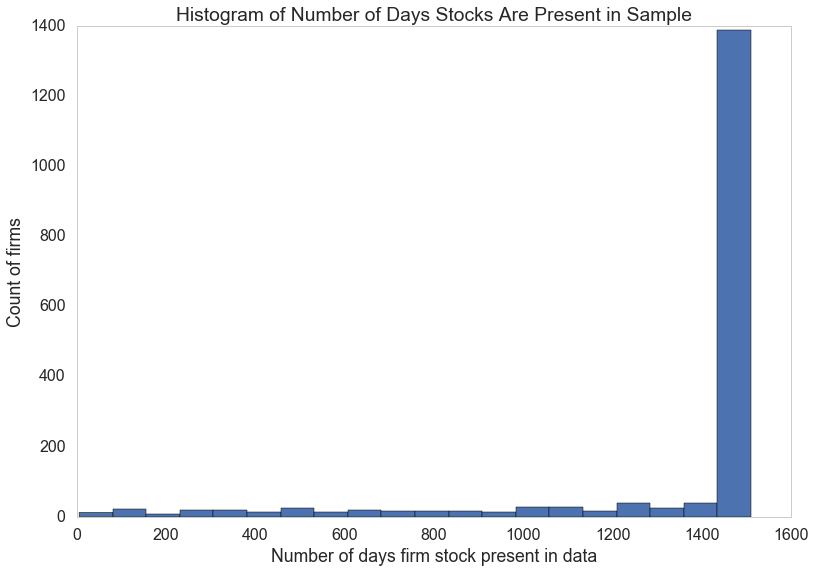

In [10]:
# check that all stocks are present on all dates in the dataset
plt.grid()
plt.title("Histogram of Number of Days Stocks Are Present in Sample")
plt.xlabel("Number of days firm stock present in data")
plt.ylabel("Count of firms")
plt.hist(financialdf.groupby("ticker").date.nunique(), bins=20);

plt.savefig('../figures/Histogram of Number of Days Stocks Are Present in Sample.png')

print "Full range of dates: ", financialdf.date.min().date(), " to ", financialdf.date.max().date()
print "Total number of business days in range: ", np.busday_count(financialdf.date.min().date(), financialdf.date.max().date())
print "Unique dates in dataset: ", financialdf.date.nunique(), "   *this number being less than the total business days is likely due to holidays"
print "# Firms appearing on all dates in dataset: ", financialdf.groupby("ticker").date.nunique()[financialdf.groupby("ticker").date.nunique().values == 1510].count()

We drop stocks that are not present for the total number of trading days.

In [11]:
# drop stocks with gaps
totaldays = financialdf.date.nunique()
financialdf = financialdf.groupby("ticker").filter(lambda x: x.date.nunique() >= totaldays)
print "# of remaining stocks: ", financialdf.ticker.nunique()

# of remaining stocks:  1358


** Save subset of stocks to be used here on **

In [12]:
financialdf.to_csv('../data/financial/only_relevant_stocks.csv')

**SIC Breakdowns + Index Belonging**

In [13]:
unsic = pd.read_csv('../data/financial/ISIC_Rev_4_english_structure.txt')

In [14]:
unsic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766 entries, 0 to 765
Data columns (total 2 columns):
Code           766 non-null object
Description    766 non-null object
dtypes: object(2)
memory usage: 12.0+ KB


In [15]:
# get industry classifications
sic = pd.read_csv('../data/financial/crsp_400_600_500_2010_2015_all_var.csv', usecols=["TICKER","HSICCD"])
sic = sic.drop_duplicates("TICKER")
sic["SIC2"] = pd.to_numeric(sic.HSICCD)
sic["HSICCD"] = pd.to_numeric(sic.HSICCD).astype(str).str[:4]
sic["SIC2"] = sic.SIC2.astype('str').str[:2]
sic = sic.merge(unsic, how='left', left_on='SIC2', right_on="Code")


In [16]:
# make custom code to pair SIC
incre = unsic[unsic.Code.apply(lambda x:len(x)) <=2].copy().reset_index().drop("index", axis=1)
indexes = incre[incre.Code.str.contains(r'[A-Z]')].index
len(incre)

# complicated stuff that shouldn't be necessary
list_ = []
for first, second in zip(list(indexes), list(indexes)[1:] + [len(incre)-1]):
        list_.append(incre[first+1:second])
        
sic2tosic1 = pd.concat(list_)
sic2tosic1["SIC1"] = np.nan
sic2tosic1["SIC1_name"] = np.nan
for first, second in zip(list(indexes), list(indexes)[1:] + [len(incre)-1]):
    sic2tosic1.loc[first+1:second,"SIC1"] = incre.loc[first,"Code"]
    sic2tosic1.loc[first+1:second,"SIC1_name"] = incre.loc[first,"Description"]

sic = sic.merge(sic2tosic1, how='left', left_on="SIC2", right_on="Code").drop(["Code_x","Description_x","Code_y"],axis=1)
sic.columns = [u'TICKER', u'HSICCD', u'SIC2', u'SIC2_name', u'SIC1', u'SIC1_name']
sic.columns = sic.columns.str.lower()

In [17]:
sic.head()

,ticker,hsiccd,sic2,sic2_name,sic1,sic1_name
0,JJSF,2052,20,Manufacture of chemicals and chemical products,C,Manufacturing
1,PLXS,3670,36,"Water collection, treatment and supply",E,"Water supply; sewerage, waste management and remediation activities"
2,HGR,8093,80,Security and investigation activities,N,Administrative and support service activities
3,ORCL,7372,73,Advertising and market research,M,"Professional, scientific and technical activities"
4,MSFT,7370,73,Advertising and market research,M,"Professional, scientific and technical activities"


In [18]:
sic = sic.merge(indexfirmdf[['co_tic','conm']], how='left',left_on='ticker', right_on="co_tic")

** SIC - Index Breakdown **

In [19]:
indxsic = sic.groupby(["sic1_name","conm"]).ticker.count().fillna(0).astype(int)
temp = pd.DataFrame(indxsic.sort_values(ascending=0)).reset_index()

# Get company 'concept uri-s' <a id=concepts></a>

The goal here is to have a mapping between company stock tickers and all likely associated concept uri-s. The strategy is as follows:
1. Get a list of company names from CRSP
2. Create a dictionary mapping tickers and sets of possible company names
3. Query EventRegistry for top Uri matches given the names in those sets
4. End up with a dictionary mapping tickers to sets of associated Concept Uri-s

## Get list of company names <a id=comnam></a>

We use the COMNAM variable from CRSP to get company names. However, this isn't totally straightforward as it seems some companies changed their names throughout time or just happened to have different ticker-name pairs.

In [20]:
# check ticker - name pairs
print "Total Unique Tickers: ", financialdf.ticker.nunique()
print "Total Unique Names: ", financialdf.comnam.nunique()

Total Unique Tickers:  1358
Total Unique Names:  1458


Let's check which tickers have multiple names and what those names are:

In [21]:
# get list of tickers with duplicate names
diffnames = financialdf.groupby('ticker').comnam.unique()
pd.DataFrame(diffnames[diffnames.apply(lambda x: len(x) > 1)]).head(30)

,comnam
ticker,
ACM,"[A E C O M TECHNOLOGY CORP, A E C O M]"
ADC,"[ASTRO DRILLING CO, AGREE REALTY CORP]"
ALEX,"[ALEXANDER & BALDWIN INC, ALEXANDER & BALDWIN HLDGS INC, ALEXANDER & BALDWIN INC NEW]"
AMT,"[AMERICAN TOWER CORP, AMERICAN TOWER CORP NEW]"
AON,"[AON CORP, AON PLC]"
APOL,"[APOLLO GROUP INC, APOLLO EDUCATION GROUP INC]"
ARRS,"[ARRIS GROUP INC, ARRIS GROUP INC NEW]"
BIIB,"[BIOGEN IDEC INC, BIOGEN INC]"
CBG,"[C B RICHARD ELLIS GROUP INC, C B R E GROUP INC]"


OK, a visual inspection indicates that these tend to be small changes in phrasing. Nevertheless, we can take advantage of these and use all names in the set to query for uri-s. This is the approach we will take below. 

## Testing getConceptUri <a id=getconcept></a>

Concept uri-s are how EventRegistry tags individual concepts and recognizes them across articles. Interestingly, they are wikipedia links, and as such also have crowdsourced hierarchical information attached. 

EventRegistry offers two functions to obtain concept uri-s. The first is "getConceptUri" which only returns the top link. We play around a bit to get a sense of how this works:

In [22]:
# coca-cola queries
colaq = []
queries = ['COCA COLA ENTERPRISES INC',  
           'COCA COLA ENTERPRISES',
           'COCA COLA INC',
           'COCA COLA']
for query in queries:
    colaq.append([query, er.getConceptUri(query)])
colaq = pd.DataFrame(colaq, columns = ["Query", "Resulting Uri"]).set_index("Query")
colaq

,Resulting Uri
Query,
COCA COLA ENTERPRISES INC,None
COCA COLA ENTERPRISES,http://en.wikipedia.org/wiki/Coca-Cola_Enterprises
COCA COLA INC,"http://en.wikipedia.org/wiki/Coca-Cola_Bottlers_Philippines,_Inc."
COCA COLA,http://en.wikipedia.org/wiki/Coca-Cola


In [23]:
# devry queries
q = []
queries = ['DEVRY INC DEL',
           'DEVRY INC',
           'DEVRY DEL',
           'DEVRY EDUCATION GROUP INC',
           'DEVRY EDUCATION GROUP',
           'DEVRY EDUCATION INC',
           'DEVRY EDUCATION',
           'DEVRY GROUP',
           'DEVRY']

for query in queries:
    q.append([query, er.getConceptUri(query)])
q = pd.DataFrame(q, columns = ["Query", "Resulting Uri"]).set_index("Query")
q

,Resulting Uri
Query,
DEVRY INC DEL,None
DEVRY INC,http://en.wikipedia.org/wiki/DeVry_Inc.
DEVRY DEL,None
DEVRY EDUCATION GROUP INC,None
DEVRY EDUCATION GROUP,http://en.wikipedia.org/wiki/DeVry_Education_Group
DEVRY EDUCATION INC,None
DEVRY EDUCATION,http://en.wikipedia.org/wiki/DeVry_Education_Group
DEVRY GROUP,http://en.wikipedia.org/wiki/DeVry_Education_Group
DEVRY,http://en.wikipedia.org/wiki/DeVry_University


In [24]:
# cvs queries
cvsq = []
queries = ['C V S CAREMARK CORP', 
           'C V S CAREMARK',
           'C V S CORP',
           'C V S HEALTH CORP',
           'C V S HEALTH',
           'C V S',
           'CVS']
for query in queries:
    cvsq.append([query, er.getConceptUri(query)])
cvsq = pd.DataFrame(cvsq, columns = ["Query", "Resulting Uri"]).set_index("Query")
cvsq

,Resulting Uri
Query,
C V S CAREMARK CORP,None
C V S CAREMARK,None
C V S CORP,None
C V S HEALTH CORP,None
C V S HEALTH,None
C V S,None
CVS,http://en.wikipedia.org/wiki/CVS_Pharmacy


In [25]:
# test more abbreviations
cvsq = []
queries = ['CVS CAREMARK CORP', 
           'CVS CAREMARK',
           'CVS CORP',
           'CVS HEALTH CORP',
           'CVS HEALTH',
           'E N S C O INTL LTD', 
           'E N S C O INTL', 
           'E N S C O PLC', 
           'E N S C O PLC NEW',
           'E N S C O',
           'ENSCO INTL LTD', 
           'ENSCO INTL', 
           'ENSCO PLC', 
           'ENSCO PLC NEW',
           'ENSCO',
           'C I G N A CORP', 
           'CIGNA CORP',
           'C I G N A', 
           'CIGNA',
           'C B RICHARD ELLIS GROUP INC', 
           'C B R E GROUP INC',
           'CB RICHARD ELLIS GROUP INC', 
           'CBRE GROUP INC',
           'C B RICHARD ELLIS GROUP', 
           'C B R E GROUP',
           'CB RICHARD ELLIS GROUP', 
           'CBRE GROUP',
           'C B RICHARD ELLIS', 
           'C B R E',
           'CB RICHARD ELLIS', 
           'CBRE']
           
for query in queries:
    cvsq.append([query, er.getConceptUri(query)])
cvsq = pd.DataFrame(cvsq, columns = ["Query", "Resulting Uri"]).set_index("Query")
cvsq

,Resulting Uri
Query,
CVS CAREMARK CORP,None
CVS CAREMARK,http://en.wikipedia.org/wiki/CVS_Caremark
CVS CORP,None
CVS HEALTH CORP,None
CVS HEALTH,None
E N S C O INTL LTD,None
E N S C O INTL,None
E N S C O PLC,None
E N S C O PLC NEW,None


In [26]:
# check if lower vs. upper caps make a difference
cvsq = []
queries = ['CVS CAREMARK CORP', 
           'CVS CAREMARK',
           'CVS CORP',
           'CVS HEALTH CORP',
           'CVS HEALTH',
           'E N S C O INTL LTD', 
           'E N S C O INTL', 
           'E N S C O PLC', 
           'E N S C O PLC NEW',
           'E N S C O',
           'ENSCO INTL LTD', 
           'ENSCO INTL', 
           'ENSCO PLC', 
           'ENSCO PLC NEW',
           'ENSCO',
           'C I G N A CORP', 
           'CIGNA CORP',
           'C I G N A', 
           'CIGNA']
           
for query in queries:
    query = query.lower()
    cvsq.append([query, er.getConceptUri(query)])
cvsq = pd.DataFrame(cvsq, columns = ["Query", "Resulting Uri"]).set_index("Query")
cvsq

,Resulting Uri
Query,
cvs caremark corp,None
cvs caremark,http://en.wikipedia.org/wiki/CVS_Caremark
cvs corp,None
cvs health corp,None
cvs health,None
e n s c o intl ltd,None
e n s c o intl,None
e n s c o plc,None
e n s c o plc new,None


It seems like two things would greatly increase the accuracy of the matches:
1. get rid of words like INC and CORP (I believe Y&I do this as well).
2. join acronyms together

It also seems not to matter whether terms are upper or lower cap.

## Ticker-name dictionary <a id=namesdict></a>

My approach for removing things like "inc", "corp", etc, will be to:
1. change all terms to lower cap
2. create a dictionary with tickers as keys and sets of company names as values
3. count the number of times individual terms appear in all the company names
4. manually screen through the top terms for anything that should probably actually be kept, select the rest for removal
5. add to each ticker's set of company names a version of the same names except with the selected terms removed

In [27]:
# create initialize ticker-name dictionary 

# change all terms to lower cap
namesdict = diffnames.to_dict()

# change arrays to lowercase sets
for ticker, names in namesdict.items():
    lowercase = set()
    for name in names:
        lowercase.add(name.lower())
    namesdict[ticker] = lowercase
    
#namesdict

In [28]:
# figure out which terms to exclude
from collections import Counter

# get a list of all terms
allwords = []
for ticker, names in namesdict.items():
    for name in names:
        allwords.extend(name.split())

Counter(allwords).most_common(25)

[('inc', 851),
 ('corp', 377),
 ('co', 110),
 ('new', 92),
 ('group', 78),
 ('&', 67),
 ('international', 50),
 ('c', 48),
 ('financial', 41),
 ('energy', 36),
 ('s', 35),
 ('holdings', 33),
 ('industries', 30),
 ('m', 29),
 ('a', 29),
 ('systems', 29),
 ('t', 27),
 ('e', 26),
 ('technologies', 25),
 ('ltd', 23),
 ('i', 23),
 ('bancorp', 22),
 ('p', 21),
 ('b', 21),
 ('n', 19)]

I remove the following terms: inc, corp, co, ltd, plc. We can explore later whether it might be judicious to remove more terms. 

In [29]:
# remove uneccesary terms
for ticker, names in namesdict.items():
    new_names = set()
    for name in names:
        new_names.add(name)
        new_names.add(re.sub(r"\b((inc)|(corp)|(co)|(ltd)|(plc))\b","", name).strip())
    namesdict[ticker] = new_names

# also remove 'group', but separately, sometimes it helps
for ticker, names in namesdict.items():
    new_names = set()
    for name in names:
        new_names.add(name)
        new_names.add(re.sub(r"\b(group)\b","", name).strip())
    namesdict[ticker] = new_names
    
# also remove 'new', but separately, sometimes it helps
for ticker, names in namesdict.items():
    new_names = set()
    for name in names:
        new_names.add(name)
        new_names.add(re.sub(r"\b(new)\b","", name).strip())
    namesdict[ticker] = new_names

Next, I concatenate all abbreviations:

In [30]:
# join abbreviations
for ticker, names in namesdict.items():
    new_names = set()
    for name in names:
        new_names.add(name)
        new_names.add(regex.sub(r"(?<=\b[a-z])[. ](?=[a-z]\b)","", name))
    namesdict[ticker] = new_names

Ok, cool, we are ready to rumble! Let's take a look at the final dictionary and our total count of requests (hopefully not more than 10,000!):

In [31]:
# take a peek
total = 0
for ticker, names in namesdict.items():
    total += len(names)

print "Total names to Query: ", total
{k: namesdict[k] for k in namesdict.keys()[:25]}

Total names to Query:  3426


{'ACET': {'aceto', 'aceto corp'},
 'CPB': {'campbell soup', 'campbell soup co'},
 'CPF': {'central pacific financial', 'central pacific financial corp'},
 'CPT': {'camden property trust'},
 'EOG': {'eog resources', 'eog resources inc'},
 'EXAR': {'exar', 'exar corp'},
 'EXLS': {'exlservice holdings', 'exlservice holdings inc'},
 'IDXX': {'i d e x x laboratories',
  'i d e x x laboratories inc',
  'idexx laboratories',
  'idexx laboratories inc'},
 'JBHT': {'hunt j b transport services',
  'hunt j b transport services inc',
  'hunt jb transport services',
  'hunt jb transport services inc'},
 'JWN': {'nordstrom', 'nordstrom inc'},
 'KLIC': {'kulicke & soffa inds', 'kulicke & soffa inds inc'},
 'KRC': {'kilroy realty', 'kilroy realty corp'},
 'LGND': {'ligand pharmaceuticals', 'ligand pharmaceuticals inc'},
 'LSTR': {'landstar system', 'landstar system inc'},
 'NDSN': {'nordson', 'nordson corp'},
 'PHM': {'pulte',
  'pulte  inc',
  'pulte group',
  'pulte group inc',
  'pulte homes',
  '

## Testing suggestConcepts <a id=suggestconcepts></a>

We now quickly explore the "suggestConcepts" function of EventRegistry. There is no reason for us to only query one article for each company, so let's see how we might most fruitfully query multiple, *relevant*, articles at once. First, let's query for coca-cola:

In [32]:
# get coca cola concepts
cc_concepts = er.suggestConcepts("coca cola")
cc_concepts

[{u'id': u'39131',
  u'label': {u'eng': u'Coca-Cola'},
  u'score': 103298,
  u'type': u'wiki',
  u'uri': u'http://en.wikipedia.org/wiki/Coca-Cola'},
 {u'id': u'95230',
  u'label': {u'eng': u'The Coca-Cola Company'},
  u'score': 11232,
  u'type': u'org',
  u'uri': u'http://en.wikipedia.org/wiki/The_Coca-Cola_Company'},
 {u'id': u'357107',
  u'label': {u'eng': u'Coca-Cola 600'},
  u'score': 3821,
  u'type': u'wiki',
  u'uri': u'http://en.wikipedia.org/wiki/Coca-Cola_600'},
 {u'id': u'174873',
  u'label': {u'eng': u'Coca-Cola Zero'},
  u'score': 2084,
  u'type': u'wiki',
  u'uri': u'http://en.wikipedia.org/wiki/Coca-Cola_Zero'},
 {u'id': u'38274',
  u'label': {u'eng': u'Coca-Cola Amatil'},
  u'score': 1546,
  u'type': u'org',
  u'uri': u'http://en.wikipedia.org/wiki/Coca-Cola_Amatil'},
 {u'id': u'186235',
  u'label': {u'eng': u'Coca-Cola Enterprises'},
  u'score': 1085,
  u'type': u'org',
  u'uri': u'http://en.wikipedia.org/wiki/Coca-Cola_Enterprises'},
 {u'id': u'1660880',
  u'label': {u

The above results can be categorized as follows:
- companies related to or owned by coca-cola (useful, easy to extract)
- coca cola products (useful, hard to extract)
- random wikipedia articles about coca cola, which, if identified in the news, could bear economic significance (useful, hard to extract)
- random wikipedia articles about coca cola, which, if identified in the news, would be unlikely to bear economic significance (not useful, hard to exract)

The one useful and easy to extract category is "organizations" or companies... We will take advantage of this later... Let us explore one more large corporation, "General Mills":

In [33]:
# get GM concepts
gm_concepts = er.suggestConcepts("general mills")
gm_concepts

[{u'id': u'41458',
  u'label': {u'eng': u'General Mills'},
  u'score': 15649,
  u'type': u'org',
  u'uri': u'http://en.wikipedia.org/wiki/General_Mills'},
 {u'id': u'181427',
  u'label': {u'eng': u'General Mills monster-themed breakfast cereals'},
  u'score': 611,
  u'type': u'wiki',
  u'uri': u'http://en.wikipedia.org/wiki/General_Mills_monster-themed_breakfast_cereals'}]

Less total results, but similar categories of results. Lastly, let us explore a very different type of firm, a financial firm:

In [34]:
# get goldman sachs concepts
gs_concepts = er.suggestConcepts("goldman sachs")
gs_concepts

[{u'id': u'20400',
  u'label': {u'eng': u'Goldman Sachs'},
  u'score': 162301,
  u'type': u'org',
  u'uri': u'http://en.wikipedia.org/wiki/Goldman_Sachs'},
 {u'id': u'234252',
  u'label': {u'eng': u'Goldman Sachs Capital Partners'},
  u'score': 209,
  u'type': u'org',
  u'uri': u'http://en.wikipedia.org/wiki/Goldman_Sachs_Capital_Partners'}]

## Exploring concept info <a id=conceptinfo></a>

It seems evident that we are better off querying for multiple concepts using suggestconcepturi instead of just one. However, it also evident that we need a better way of finding which concepts should really matter. In order to do that, we explore conceptinfo tags next, to see what we might be able to use to our advantage.

Because they are large, well known, and yet very different firms, we explore Coca-Cola and Goldman Sachs:

In [35]:
# define what info we are interested in
conceptflags = ConceptInfoFlags(type = "concepts",lang = "eng",label = False,synonyms = False,image = False,
                 description = False,details = False,conceptClassMembership = True,
                 conceptClassMembershipFull = True,conceptFolderMembership = True,trendingScore = False,
                 trendingHistory = False,trendingSource = "news")

In [36]:
# update goldman sachs info
for i, concept in enumerate(gs_concepts):
    concept.update(er.getConceptInfo(concept['uri'], returnInfo= ReturnInfo(conceptInfo = conceptflags))[concept['uri']])
gs_concepts

[{u'conceptClassMembership': [u'http://dbpedia.org/ontology/Company'],
  u'conceptClassMembershipFull': [u'http://dbpedia.org/ontology/Company',
   u'http://dbpedia.org/ontology/Organisation',
   u'http://dbpedia.org/ontology/Agent'],
  u'conceptFolderMembership': [],
  u'id': u'20400',
  u'label': {u'eng': u'Goldman Sachs'},
  u'score': 162301,
  u'type': u'org',
  u'uri': u'http://en.wikipedia.org/wiki/Goldman_Sachs'},
 {u'conceptClassMembership': [u'http://dbpedia.org/ontology/Company'],
  u'conceptClassMembershipFull': [u'http://dbpedia.org/ontology/Company',
   u'http://dbpedia.org/ontology/Organisation',
   u'http://dbpedia.org/ontology/Agent'],
  u'conceptFolderMembership': [],
  u'id': u'234252',
  u'label': {u'eng': u'Goldman Sachs Capital Partners'},
  u'score': 209,
  u'type': u'org',
  u'uri': u'http://en.wikipedia.org/wiki/Goldman_Sachs_Capital_Partners'}]

In [37]:
# update coca cola info
for concept in cc_concepts:
    concept.update(er.getConceptInfo(concept['uri'], returnInfo= ReturnInfo(conceptInfo = conceptflags))[concept['uri']])
cc_concepts

[{u'conceptClassMembership': [u'http://dbpedia.org/ontology/Beverage'],
  u'conceptClassMembershipFull': [u'http://dbpedia.org/ontology/Beverage',
   u'http://dbpedia.org/ontology/Food'],
  u'conceptFolderMembership': [],
  u'id': u'39131',
  u'label': {u'eng': u'Coca-Cola'},
  u'score': 103298,
  u'type': u'wiki',
  u'uri': u'http://en.wikipedia.org/wiki/Coca-Cola'},
 {u'conceptClassMembership': [u'http://dbpedia.org/ontology/Company'],
  u'conceptClassMembershipFull': [u'http://dbpedia.org/ontology/Company',
   u'http://dbpedia.org/ontology/Organisation',
   u'http://dbpedia.org/ontology/Agent'],
  u'conceptFolderMembership': [],
  u'id': u'95230',
  u'label': {u'eng': u'The Coca-Cola Company'},
  u'score': 11232,
  u'type': u'org',
  u'uri': u'http://en.wikipedia.org/wiki/The_Coca-Cola_Company'},
 {u'conceptClassMembership': [],
  u'conceptClassMembershipFull': [],
  u'conceptFolderMembership': [],
  u'id': u'357107',
  u'label': {u'eng': u'Coca-Cola 600'},
  u'score': 3821,
  u'typ

It appears that the conceptClassMembership could be used to find concepts which are *products* of the companies we are querying. This would be pretty cool, as it could add to the reach of our co-occurence graph in a likely significant way. Let's see what we get with Apple:

In [38]:
# checking out apple
i_concepts = er.suggestConcepts("apple")
i_concepts

for concept in i_concepts:
    concept.update(er.getConceptInfo(concept['uri'], returnInfo= ReturnInfo(conceptInfo = conceptflags))[concept['uri']])
i_concepts

[{u'conceptClassMembership': [u'http://dbpedia.org/ontology/Company'],
  u'conceptClassMembershipFull': [u'http://dbpedia.org/ontology/Company',
   u'http://dbpedia.org/ontology/Organisation',
   u'http://dbpedia.org/ontology/Agent'],
  u'conceptFolderMembership': [],
  u'id': u'20886',
  u'label': {u'eng': u'Apple Inc.'},
  u'score': 1012138,
  u'type': u'wiki',
  u'uri': u'http://en.wikipedia.org/wiki/Apple_Inc.'},
 {u'conceptClassMembership': [u'http://dbpedia.org/ontology/Plant'],
  u'conceptClassMembershipFull': [u'http://dbpedia.org/ontology/Plant',
   u'http://dbpedia.org/ontology/Eukaryote',
   u'http://dbpedia.org/ontology/Species'],
  u'conceptFolderMembership': [],
  u'id': u'27800',
  u'label': {u'eng': u'Apple'},
  u'score': 170883,
  u'type': u'wiki',
  u'uri': u'http://en.wikipedia.org/wiki/Apple'},
 {u'conceptClassMembership': [],
  u'conceptClassMembershipFull': [],
  u'conceptFolderMembership': [],
  u'id': u'215318',
  u'label': {u'eng': u'Apple iOS'},
  u'score': 62

OK, for now, it seems like just filter on type='org' is the most efficient and holistic way of getting relevant concepts. Let's move on and finally get these uri-s.   

## Ticker-uri dictionary <a id=ticdict></a>

Essentially, what I do here, is get all the uri-s that might apply to a ticker based on all the names we have made for it... Let's run a test before we waste 3000 requests...

In [39]:
%%time
# run test version, 5 tickers
uridict = {}
i=0

# we add the test to see what happens when no concepts are found
for ticker, nameset in ([("TEST", ["asdvboasdjhvbzh"])] + namesdict.items()):
    ticker_uris_dict = {}
    for name in nameset:
        concepts = er.suggestConcepts(name)
        for concept in concepts:
            if concept['uri'] not in ticker_uris_dict:
                ticker_uris_dict[concept['uri']] = concept
    uridict[ticker] = ticker_uris_dict
    
    i += 1
    if i == 4:
        break

Wall time: 7.13 s


In [40]:
uridict

{'NDSN': {u'http://en.wikipedia.org/wiki/Nordson_Corporation': {u'id': u'1307928',
   u'label': {u'eng': u'Nordson Corporation'},
   u'score': 285,
   u'type': u'org',
   u'uri': u'http://en.wikipedia.org/wiki/Nordson_Corporation'}},
 'PKY': {u'http://en.wikipedia.org/wiki/Parkway_Properties': {u'id': u'1669686',
   u'label': {u'eng': u'Parkway Properties'},
   u'score': 128,
   u'type': u'org',
   u'uri': u'http://en.wikipedia.org/wiki/Parkway_Properties'}},
 'RYN': {u'http://en.wikipedia.org/wiki/Rayonier': {u'id': u'105755',
   u'label': {u'eng': u'Rayonier'},
   u'score': 1156,
   u'type': u'org',
   u'uri': u'http://en.wikipedia.org/wiki/Rayonier'}},
 'TEST': {}}

OK. That looks like it is working. Entries that have no matches will simply have empty dictionaries, which is pretty easy to query for later, so let's do this, wahoo! 

In [41]:
"""
%%time
uridict = {}
for ticker, nameset in namesdict.items():
    ticker_uris_dict = {}
    for name in nameset:
        concepts = er.suggestConcepts(name)
        for concept in concepts:
            if concept['uri'] not in ticker_uris_dict:
                ticker_uris_dict[concept['uri']] = concept
    uridict[ticker] = ticker_uris_dict
""";

In [42]:
# we save the results as a json file to preserve the information structure
"""
with open('../data/uridict.json', 'w') as fp:
    json.dump(uridict, fp, indent=4)
""";

with open('../data/uridict.json', 'r') as fp:
    uridict = json.load(fp)


## Analyzing uri yields

### Overall yield

In [43]:
# get some yield summarty stats
ticker_uri_counts = []
for ticker, uridicts in uridict.items():
    ticker_uri_counts.append([ticker, len(uridicts)])
uricounts = pd.DataFrame(ticker_uri_counts, columns=["Ticker","Uri Count"])
uricounts.set_index('Ticker', inplace=1)

print "Total number of tickers: ", len(uricounts.index)
print "Number of tickers with no uri: ", uricounts['Uri Count'].value_counts().loc[0,]
yield_ = 100 * (float(len(uricounts.index)) - uricounts['Uri Count'].value_counts().loc[0,]) / len(uricounts.index)
print "Rough Yield: {:,.2f}%".format(yield_)

Total number of tickers:  1358
Number of tickers with no uri:  459
Rough Yield: 66.20%


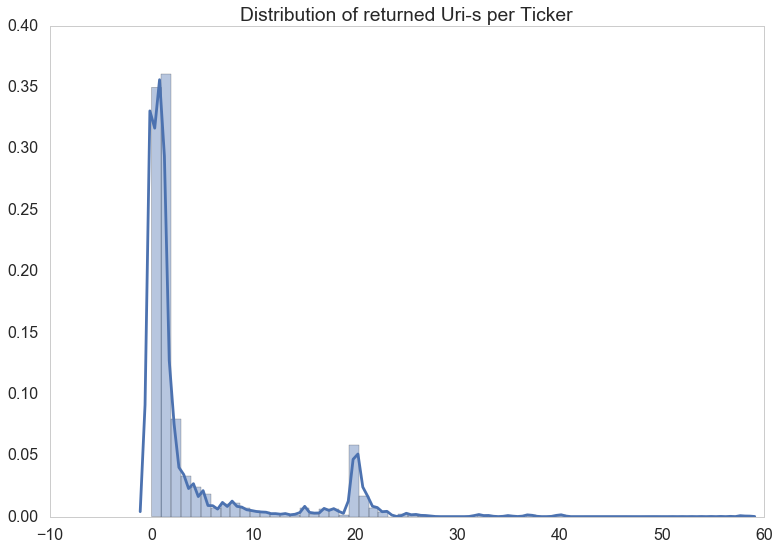

In [44]:
# plot hist
plt.grid()
plt.title("Distribution of returned Uri-s per Ticker")
sns.distplot(uricounts, norm_hist=False, bins=60)

In [45]:
# show exact table of distribution
distribution = pd.DataFrame(uricounts['Uri Count'].value_counts())
distribution.reset_index(inplace=1)
distribution.columns = [["Number of uri-s assigned to Ticker", "Count of Tickers"]]
distribution.set_index("Number of uri-s assigned to Ticker",inplace=1)
distribution.head(5)

,Count of Tickers
Number of uri-s assigned to Ticker,
1,473
0,459
2,104
20,77
3,43


**Notes on overall yield**
- this is great! In the first pilot test that I did, my yield was about 38 associated uri-s out of 300 tickers, so we have made this whole process about 6 times more effective, and raised the yield from about 10% to 66% by doing some simple company name cleaning. Plus, we now have multiple uri-s per ticker.

- The distribution makes sense. The default limit on return URI-s, which I left in place during this process, is 20 uri-s. As such, it makes sense that we would have a bimodal distribution. The only way you can have more than 20 results is if two different names yield different uri-s. 

Let's move on to examine this to some more detail:

### Yield by sector & index

In [46]:
# get company names
SIC = pd.read_csv("../data/financial/crsp_400_600_500_2010_2015_ticker_comnam_SIC2.csv")
uricounts["comnames"] = diffnames
uricounts = uricounts.merge(sic,how='left',left_index=1,right_on='ticker')

In [47]:
# uri matching by sector
def count_fail(x):
    return (x == 0).sum()
def share_fail(x):
    return (x == 0).sum() / float(x.count()) * 100

bysector = uricounts.groupby("sic1_name")["Uri Count"].agg(['count', count_fail, share_fail, np.mean, np.median, np.max, np.min, np.std])
bysector.sort_values('share_fail')

,count,count_fail,share_fail,mean,median,amax,amin,std
sic1_name,,,,,,,,
Financial and insurance activities,8,1,12.50000,6.12500,1,20,0,8.69216
"Water supply; sewerage, waste management and remediation activities",215,50,23.25581,4.50698,1,35,0,7.19220
Human health and social work activities,29,7,24.13793,4.31034,1,21,0,7.16691
"Electricity, gas, steam and air conditioning supply",77,20,25.97403,5.45455,1,33,0,8.05335
Transportation and storage,136,36,26.47059,3.07353,1,37,0,5.94746
Accommodation and food service activities,33,9,27.27273,2.90909,1,23,0,5.94434
Manufacturing,336,96,28.57143,3.87798,1,40,0,6.96901
"Professional, scientific and technical activities",138,48,34.78261,3.32609,1,40,0,6.72088
Administrative and support service activities,47,18,38.29787,3.89362,1,21,0,6.59787


In [48]:
# failed matches by sector / index
uricounts[uricounts["Uri Count"] == 0].groupby(["sic1_name","conm"]).ticker.count().unstack()

conm,S&P 500 Comp-Ltd,S&P Midcap 400 Index,S&P Smallcap 600 Index
sic1_name,,,
Accommodation and food service activities,2.00000,2.00000,5.00000
Administrative and support service activities,1.00000,4.00000,11.00000
Construction,1.00000,1.00000,2.00000
"Electricity, gas, steam and air conditioning supply",3.00000,5.00000,12.00000
Financial and insurance activities,1.00000,nan,nan
Human health and social work activities,nan,3.00000,4.00000
Information and communication,16.00000,34.00000,64.00000
Manufacturing,12.00000,18.00000,61.00000
"Professional, scientific and technical activities",12.00000,11.00000,25.00000


** Notes on Sector / Index Breakdown **
- the sectors with the lowest yield are "Wholesale and retail trade; repair of motor vehicles and motorcycles", "Information and communication", "Construction" and "Professional, scientific and technical activities". 
- the sectors with the highest yield are "Financial and insurance activities", "Water supply; sewerage, waste management and remediation activities", "Human health and social work activities". 
- note quite sure what to make of the first two points
- the majority of unmatched tickers are from the S&P Smallcap 600 Index, this is much less surprising and matches intuition that larger companies would get more attention (note, S&P 600 has more firms in the sample in the first place, but still outweighs the others in unmatched tickers even relative to that). 

### Unmatched tickers

Let's just look at unmatched names now and see if there are any trends:

In [49]:
uricounts[uricounts["Uri Count"] == 0][:20]

,Uri Count,comnames,ticker,hsiccd,sic2,sic2_name,sic1,sic1_name,co_tic,conm
1779,0,[EXLSERVICE HOLDINGS INC],EXLS,7389,73,Advertising and market research,M,"Professional, scientific and technical activities",EXLS,S&P Smallcap 600 Index
70,0,[CENTRAL PACIFIC FINANCIAL CORP],CPF,6022,60,Programming and broadcasting activities,J,Information and communication,CPF,S&P Smallcap 600 Index
579,0,[KULICKE & SOFFA INDS INC],KLIC,3560,35,"Electricity, gas, steam and air conditioning supply",D,"Electricity, gas, steam and air conditioning supply",KLIC,S&P Smallcap 600 Index
1307,0,[KILROY REALTY CORP],KRC,6798,67,NaN,NaN,NaN,KRC,S&P Midcap 400 Index
359,0,[HALLIBURTON COMPANY],HAL,1389,13,Manufacture of textiles,C,Manufacturing,HAL,S&P 500 Comp-Ltd
524,0,[HUNT J B TRANSPORT SERVICES INC],JBHT,4213,42,Civil engineering,F,Construction,JBHT,S&P 500 Comp-Ltd
525,0,[HUNT J B TRANSPORT SERVICES INC],JBHT,4213,42,Civil engineering,F,Construction,JBHT,S&P Midcap 400 Index
1832,0,[RETAIL OPPORTUNITY INVST CORP],ROIC,9999,99,NaN,NaN,NaN,ROIC,S&P Smallcap 600 Index
1889,0,[KRATON PERFORMANCE POLYMERS INC],KRA,2821,28,Manufacture of machinery and equipment n.e.c.,C,Manufacturing,KRA,S&P Smallcap 600 Index
1467,0,"[ALLSCRIPTS MISYS HEALTHCARE SOLS, ALLSCRIPTS HEALTHCARE SOLNS INC]",MDRX,7372,73,Advertising and market research,M,"Professional, scientific and technical activities",MDRX,S&P Midcap 400 Index


I expected that most of these companies simply wouldn't have wikipedia pages and so I googled their names + "wiki". However, the distribution of companies with dedicated wikipedia pages (showing up as the first result of that query) and this without, is pretty even. It almost odd. Let's check, maybe the problem is just that despite the existence of wikipedia pages, there is no associated uri. I take "Comfort Systems USA" to test:

In [50]:
er.getConceptInfo("https://en.wikipedia.org/wiki/Comfort_Systems_USA")

{u'https://en.wikipedia.org/wiki/Comfort_Systems_USA': {u'error': u"Provided uri ('https://en.wikipedia.org/wiki/Comfort_Systems_USA') is not valid concept uri."}}

Yah, ok, despite existence of wikipedia page, simply isn't loaded as a uri or concept. 

### Highly matched tickers

Ok, let's take a look at the opposite now, the most highly matched results, as well as what the results are:

In [51]:
# looking at the top 30 results
uricounts[["ticker","Uri Count", "comnames", "sic1_name"]].sort_values("Uri Count", ascending=0)[:30]

,ticker,Uri Count,comnames,sic1_name
1153,GEO,58,"[GEO GROUP INC, GEO GROUP INC NEW]",NaN
745,UNT,40,[UNIT CORP],Manufacturing
746,UNT,40,[UNIT CORP],Manufacturing
391,CA,40,[C A INC],"Professional, scientific and technical activities"
396,DIS,37,[DISNEY WALT CO],NaN
287,SO,37,[SOUTHERN CO],Transportation and storage
694,INTC,35,[INTEL CORP],"Water supply; sewerage, waste management and remediation activities"
204,AAPL,33,[APPLE INC],"Electricity, gas, steam and air conditioning supply"
181,NWSA,32,"[NEWS CORP NEW, NEWS CORP]",NaN
182,NWSA,32,"[NEWS CORP NEW, NEWS CORP]",NaN


So, unfortunately, it seems like a majority of these companies do not differentiate themselves from others by their fame or public image, but instead just differentiate themselves by being very short, or easily confoundable with other companies. Let's see what the uri lists look like for some of the these examples and whether we can mitigate this issue by narrowing down on 'org' types. We first look at GEO Inc.

In [52]:
# GEO INC Uri-s
uridict["GEO"]

{u'http://en.wikipedia.org/wiki/2007_Georgia_missile_incident': {u'id': u'1151102',
  u'label': {u'eng': u'2007 Georgia missile incident'},
  u'score': 30,
  u'type': u'wiki',
  u'uri': u'http://en.wikipedia.org/wiki/2007_Georgia_missile_incident'},
 u'http://en.wikipedia.org/wiki/Address_(geography)': {u'id': u'21113',
  u'label': {u'eng': u'Address (geography)'},
  u'score': 67307,
  u'type': u'wiki',
  u'uri': u'http://en.wikipedia.org/wiki/Address_(geography)'},
 u'http://en.wikipedia.org/wiki/Affine_plane_(incidence_geometry)': {u'id': u'1715845',
  u'label': {u'eng': u'Affine plane (incidence geometry)'},
  u'score': 0,
  u'type': u'wiki',
  u'uri': u'http://en.wikipedia.org/wiki/Affine_plane_(incidence_geometry)'},
 u'http://en.wikipedia.org/wiki/Black_Hills_Institute_of_Geological_Research,_Inc.': {u'id': u'592923',
  u'label': {u'eng': u'Black Hills Institute of Geological Research, Inc.'},
  u'score': 128,
  u'type': u'org',
  u'uri': u'http://en.wikipedia.org/wiki/Black_Hill

In [53]:
# filtering for organization uri-s
geouridict = {}
for key, values in uridict["GEO"].items():
    if values['type'] == 'org':
        geouridict[key] = values
geouridict

{u'http://en.wikipedia.org/wiki/Black_Hills_Institute_of_Geological_Research,_Inc.': {u'id': u'592923',
  u'label': {u'eng': u'Black Hills Institute of Geological Research, Inc.'},
  u'score': 128,
  u'type': u'org',
  u'uri': u'http://en.wikipedia.org/wiki/Black_Hills_Institute_of_Geological_Research,_Inc.'},
 u'http://en.wikipedia.org/wiki/GEO_Group': {u'id': u'81365',
  u'label': {u'eng': u'GEO Group'},
  u'score': 1389,
  u'type': u'org',
  u'uri': u'http://en.wikipedia.org/wiki/GEO_Group'},
 u'http://en.wikipedia.org/wiki/GEO_Group_Australia': {u'id': u'2029869',
  u'label': {u'eng': u'GEO Group Australia'},
  u'score': 2,
  u'type': u'org',
  u'uri': u'http://en.wikipedia.org/wiki/GEO_Group_Australia'},
 u'http://en.wikipedia.org/wiki/General_Electric': {u'id': u'32343',
  u'label': {u'eng': u'General Electric (GEOO34.SA)'},
  u'score': 84204,
  u'type': u'org',
  u'uri': u'http://en.wikipedia.org/wiki/General_Electric'},
 u'http://en.wikipedia.org/wiki/Geographical_Names_Board_o

Narrowing down on organizations definitely makes things better, nevertheless, the accuracy is fairly bad. We might need to just exclude entities with too many uri-s. We examine the results of one more company with many Uri-s, Microsoft Corp:

In [54]:
# microsoft Uri-s
uridict["MSFT"]

{u'http://en.wikipedia.org/wiki/Apple_Computer,_Inc._v._Microsoft_Corporation': {u'id': u'570967',
  u'label': {u'eng': u'Apple Computer, Inc. v. Microsoft Corp.'},
  u'score': 89,
  u'type': u'wiki',
  u'uri': u'http://en.wikipedia.org/wiki/Apple_Computer,_Inc._v._Microsoft_Corporation'},
 u'http://en.wikipedia.org/wiki/History_of_Microsoft_Windows': {u'id': u'20840',
  u'label': {u'eng': u'History of Microsoft Windows'},
  u'score': 13940,
  u'type': u'wiki',
  u'uri': u'http://en.wikipedia.org/wiki/History_of_Microsoft_Windows'},
 u'http://en.wikipedia.org/wiki/List_of_assets_owned_by_Microsoft_Corporation': {u'id': u'1009458',
  u'label': {u'eng': u'List of assets owned by Microsoft Corporation'},
  u'score': 590,
  u'type': u'wiki',
  u'uri': u'http://en.wikipedia.org/wiki/List_of_assets_owned_by_Microsoft_Corporation'},
 u'http://en.wikipedia.org/wiki/Microsoft': {u'id': u'20600',
  u'label': {u'eng': u'Microsoft'},
  u'score': 560627,
  u'type': u'org',
  u'uri': u'http://en.wik

So, for a company like Microsoft, we see that the uri list actually works really well, almost all concepts are directly related to the company and would make sense to include in a co-occurrence test. 

In [55]:
orguridict = {}
for key, values in uridict["MSFT"].items():
    if values['type'] == 'org':
        orguridict[key] = values
orguridict

{u'http://en.wikipedia.org/wiki/Microsoft': {u'id': u'20600',
  u'label': {u'eng': u'Microsoft'},
  u'score': 560627,
  u'type': u'org',
  u'uri': u'http://en.wikipedia.org/wiki/Microsoft'},
 u'http://en.wikipedia.org/wiki/Microsoft_Research': {u'id': u'151137',
  u'label': {u'eng': u'Microsoft Research'},
  u'score': 3507,
  u'type': u'org',
  u'uri': u'http://en.wikipedia.org/wiki/Microsoft_Research'},
 u'http://en.wikipedia.org/wiki/Microsoft_Store': {u'id': u'27589',
  u'label': {u'eng': u'Microsoft Store'},
  u'score': 3824,
  u'type': u'org',
  u'uri': u'http://en.wikipedia.org/wiki/Microsoft_Store'}}

We get Microsoft, Microsoft Research, and Microsoft Store. All relevant.

### Cleaning Uri-s

There is a clear trade-off in the decision to narrow down our uri sets for each ticker. We clean them now such that they only include organization types and see how many ticker's with any uri-s we are left with at all...

In [56]:
# we make a new dictionary which only includes uri-s of the type 'org'
org_uridict = {}
for ticker, tickerdict in uridict.items():    
    newtickerdict = {}
    for uri, uridata in tickerdict.items():
        if uridata['type'] == 'org':
            newtickerdict[uri] = uridata 
    org_uridict[ticker] = newtickerdict

In [57]:
{k: org_uridict[k] for k in org_uridict.keys()[:4]}

{u'BMI': {},
 u'EOG': {u'http://en.wikipedia.org/wiki/EOG_Resources': {u'id': u'42960',
   u'label': {u'eng': u'EOG Resources'},
   u'score': 2432,
   u'type': u'org',
   u'uri': u'http://en.wikipedia.org/wiki/EOG_Resources'}},
 u'NDSN': {u'http://en.wikipedia.org/wiki/Nordson_Corporation': {u'id': u'1307928',
   u'label': {u'eng': u'Nordson Corporation'},
   u'score': 285,
   u'type': u'org',
   u'uri': u'http://en.wikipedia.org/wiki/Nordson_Corporation'}},
 u'RYN': {u'http://en.wikipedia.org/wiki/Rayonier': {u'id': u'105755',
   u'label': {u'eng': u'Rayonier'},
   u'score': 1156,
   u'type': u'org',
   u'uri': u'http://en.wikipedia.org/wiki/Rayonier'}}}

### Analysis of Cleaned uri-s

#### Overall

In [58]:
# get some yield summarty stats
ticker_uri_counts = []
for ticker, org_uridicts in org_uridict.items():
    ticker_uri_counts.append([ticker, len(org_uridicts)])
uricounts = pd.DataFrame(ticker_uri_counts, columns=["Ticker","Uri Count"])
uricounts.set_index('Ticker', inplace=1)

print "Total number of tickers: ", len(uricounts.index)
print "Number of tickers with no uri: ", uricounts['Uri Count'].value_counts().loc[0,]
yield_ = 100 * (float(len(uricounts.index)) - uricounts['Uri Count'].value_counts().loc[0,]) / len(uricounts.index)
print "Rough Yield: {:,.2f}%".format(yield_)

Total number of tickers:  1358
Number of tickers with no uri:  567
Rough Yield: 58.25%


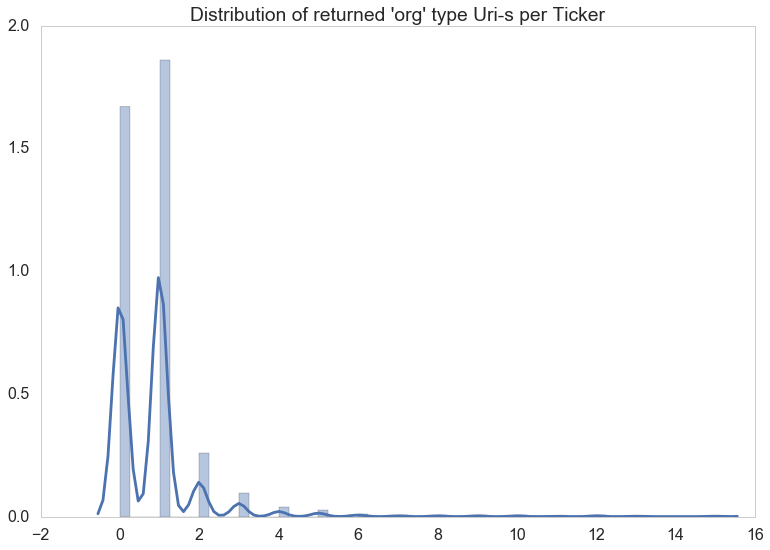

In [59]:
# plot hist
plt.grid()
plt.title("Distribution of returned 'org' type Uri-s per Ticker")
sns.distplot(uricounts, norm_hist=False, bins=60)

In [60]:
# show exact table of distribution
distribution = pd.DataFrame(uricounts['Uri Count'].value_counts())
distribution.reset_index(inplace=1)
distribution.columns = [["Number of uri-s assigned to Ticker", "Count of Tickers"]]
distribution.set_index("Number of uri-s assigned to Ticker",inplace=1)
distribution.head(5)

,Count of Tickers
Number of uri-s assigned to Ticker,
1,631
0,567
2,88
3,33
4,13


Ok, this wasn't as bad as I feared. It only increased the number of tickers without a uri from 493 to 612. We can get rid of those without losing too much.

#### Examining Top Extremes

In [61]:
top_tickers = list(uricounts.sort_values('Uri Count', ascending=0)[:10].index)
diffnames.reset_index()[diffnames.reset_index().ticker.apply(lambda x: x in top_tickers)]

,ticker,comnam
267,CMCSA,[COMCAST CORP NEW]
369,DIS,[DISNEY WALT CO]
525,GEO,"[GEO GROUP INC, GEO GROUP INC NEW]"
905,NWSA,"[NEWS CORP NEW, NEWS CORP]"
1124,SO,[SOUTHERN CO]
1230,TWC,[TIME WARNER CABLE INC]
1232,TWX,[TIME WARNER INC NEW]
1260,UNT,[UNIT CORP]
1293,VSAT,[VIASAT INC]
1345,XL,"[X L CAPITAL LTD, X L GROUP PLC]"


In [62]:
topticker_orguris = {}
for ticker in top_tickers:
    topticker_orguris[ticker] = org_uridict[ticker]
#topticker_orguris

OK, visual inspection shows that most of these really are just companies with tons of different subsidiaries or versions... Hence, we will not remove them.

OK, we now remove the tickers with no uri-s form our list and proceed to query articles and events.

In [63]:
ticker_organization_uris = {}
for ticker, uridicts in org_uridict.items():
    if len(uridicts) != 0:
        ticker_organization_uris[ticker] = uridicts

In [64]:
len(ticker_organization_uris)

791

Ok, so our total sample is 791 companies. 

# Querying News <a id=news></a>

## Articles <a id=articles></a>

In [65]:
"""
%%time

#{k:v for k,v in ticker_organization_uris.items()[:4]}
ticker_articles_dict = collections.defaultdict(dict)
i = 0
for ticker, tmp_urisdict in ticker_organization_uris.items():
    i += 1
    
    # get list of uri-s
    tickeruris = []
    tickerqueries = {}
    for uris, uri_info in tmp_urisdict.items():
        tickeruris.append(uris)
    
    
    # get articles querying for any of the uri's
    tickerqueries['articles'] = QueryArticles(conceptUri = tickeruris, conceptOper = "OR")
    tickerqueries['articles'].addRequestedResult(RequestArticlesUriList(count=50000))
    ticker_articles_dict[ticker]["articles"] = er.execQuery(tickerqueries['articles'])
    if i % 50 == 0:
        print i
"""
"""    
    tickerqueries['times'] = QueryArticles(conceptUri = tickeruris, conceptOper = "OR")
    tickerqueries['times'].addRequestedResult(RequestArticlesTimeAggr())
    ticker_articles_dict[ticker]["times"] = er.execQuery(tickerqueries['times'])

    tickerqueries['sources'] = QueryArticles(conceptUri = tickeruris, conceptOper = "OR")
    tickerqueries['sources'].addRequestedResult(RequestArticlesSourceAggr())
    ticker_articles_dict[ticker]["sources"] = er.execQuery(tickerqueries['sources'])
""";    

In [66]:
# save so no more requesting
"""
with open('../data/ticker_articles_dict.json', 'w') as fp:
    json.dump(ticker_articles_dict, fp, indent=4)
"""

with open('../data/ticker_articles_dict.json', 'r') as fp:
    ticker_articles_dict = json.load(fp)

In [118]:
# Get Counts per ticker
ticker_article_count = {}
for ticker, articles_dict in ticker_articles_dict.items():
    if u'articles' in articles_dict:
        if u'uriList' in articles_dict['articles']:
            ticker_article_count[ticker] = articles_dict['articles']['uriList']['count']
            continue
    ticker_article_count[ticker] = 0

ticker_article_count_df = pd.DataFrame.from_dict(ticker_article_count, orient='index')
ticker_article_count_df.to_csv('../data/ticker_article_count_df.csv')

In [125]:
ticker_article_count_df.describe()

,0
count,791.00000
mean,"50,000.00000"
std,0.00000
min,"50,000.00000"
25%,"50,000.00000"
50%,"50,000.00000"
75%,"50,000.00000"
max,"50,000.00000"


## Events <a id=events></a>

In [67]:
"""
%%time
ticker_events_dict = collections.defaultdict(dict)
i = 0
for ticker, tmp_urisdict in ticker_organization_uris.items():
    i += 1
    # get list of uri-s
    tickeruris = []
    for uris, uri_info in tmp_urisdict.items():
        tickeruris.append(uris)
    
    # get events querying for any of the uri's
    q = QueryEvents(conceptUri = tickeruris, conceptOper = "OR")
    q.addRequestedResult(RequestEventsUriList(count=50000))
    ticker_events_dict[ticker]["events"] = er.execQuery(q)
    if i % 50 == 0:
        print i
"""
"""    
    q = QueryEvents(conceptUri = tickeruris, conceptOper = "OR")
    q.addRequestedResult(RequestEventsTimeAggr())
    ticker_events_dict[ticker]["times"] = er.execQuery(q)

    q = QueryEvents(conceptUri = tickeruris, conceptOper = "OR")
    q.addRequestedResult(RequestEventsSourceAggr())
    ticker_events_dict[ticker]["sources"] = er.execQuery(q)

    q = QueryEvents(conceptUri = tickeruris, conceptOper = "OR")
    q.addRequestedResult(RequestEventsCategoryAggr())
    ticker_events_dict[ticker]["categories"] = er.execQuery(q)
"""    


'    \n    q = QueryEvents(conceptUri = tickeruris, conceptOper = "OR")\n    q.addRequestedResult(RequestEventsTimeAggr())\n    ticker_events_dict[ticker]["times"] = er.execQuery(q)\n\n    q = QueryEvents(conceptUri = tickeruris, conceptOper = "OR")\n    q.addRequestedResult(RequestEventsSourceAggr())\n    ticker_events_dict[ticker]["sources"] = er.execQuery(q)\n\n    q = QueryEvents(conceptUri = tickeruris, conceptOper = "OR")\n    q.addRequestedResult(RequestEventsCategoryAggr())\n    ticker_events_dict[ticker]["categories"] = er.execQuery(q)\n'

In [68]:
"""with open('../data/ticker_events_dict.json', 'w') as fp:
    json.dump(ticker_events_dict, fp, indent=4)
"""
with open('../data/ticker_events_dict.json', 'r') as fp:
    ticker_events_dict = json.load(fp)

In [121]:
# Get Counts per ticker
ticker_event_count = {}
for ticker, events_dict in ticker_events_dict.items():
    if u'events' in events_dict:
        if u'uriList' in events_dict['events']:
            ticker_event_count[ticker] = events_dict['events']['uriList']['count']
            continue
    ticker_event_count[ticker] = 0

ticker_event_count_df = pd.DataFrame.from_dict(ticker_event_count, orient='index')
ticker_event_count_df.to_csv('../data/ticker_event_count_df.csv')

In [124]:
ticker_event_count_df.describe()

,0
count,791.00000
mean,"49,115.04425"
std,"6,596.94319"
min,0.00000
25%,"50,000.00000"
50%,"50,000.00000"
75%,"50,000.00000"
max,"50,000.00000"


In [122]:
# get remaining requests
er.getRemainingAvailableRequests()

9748

# News Cosines <a id=newscosines></a>

## Articles

In [70]:
# get dict of concepts and articles
ticker_article_set_dict = {}
tickerslist = []
for ticker, articleinfo in ticker_articles_dict.items():
    # check that there are any articles at all
    if len(articleinfo["articles"]) > 0:
        ticker_article_set_dict[ticker] = set(articleinfo["articles"]['uriList']['results'])
        tickerslist.append(ticker)

In [71]:
#{k:v for k,v in ticker_article_set_dict.items()[:2]}

In [72]:
%%time
article_cosine_df = pd.DataFrame(index=tickerslist,columns=tickerslist)
i=0
for ticker_i in tickerslist:
    for ticker_j in tickerslist:
        i+=1
        article_cosine_df.loc[ticker_i, ticker_j] = (len(ticker_article_set_dict[ticker_i].intersection(ticker_article_set_dict[ticker_j])) 
                                    / np.sqrt(len(ticker_article_set_dict[ticker_i]) * len(ticker_article_set_dict[ticker_j])))
        if i % 25000 == 0:
            print i

25000
50000
75000
100000
125000
150000
175000
200000
225000
250000
275000
300000
325000
350000
375000
400000
425000
450000
475000
500000
525000
550000
575000
600000
625000
Wall time: 3min 22s


In [73]:
# sanity checks
article_cosine_df.info()
article_cosine_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 791 entries, RYN to CECO
Columns: 791 entries, RYN to CECO
dtypes: object(791)
memory usage: 4.8+ MB


,RYN,NDSN,PKY,EOG,LSTR,VSAT,CPB,NYT,SMTC,IDXX,SIG,JWN,CPT,MANT,AVAV,QLGC,NILE,VRTX,BWA,MANH,VRTS,VRTU,CCOI,SPG,ENDP,GIS,VAL,AEP,ADTN,ROP,GE,GD,SRCL,VAR,BYD,JNS,MAS,MAR,MAT,SNA,LAD,CTCT,SNI,ITRI,MAC,JNJ,ODFL,SNX,CKP,TSN,...,BRS,LEN,EBAY,BRO,MET,MDT,BRC,TWC,AZO,CPLA,REG,AZZ,PDCO,MTSC,NEWP,KELYA,MSA,TXN,DAL,HES,ORCL,DUK,TE,EAT,PXD,AA,HOG,ADI,NE,CNP,SANM,CNX,WAB,ROK,TSRA,SCI,CNL,ISRG,ESV,IPXL,DSPG,EQIX,PFG,BKH,MCS,CATO,VSH,VSI,PNRA,CECO
RYN,1.00000,0.00000,0.00000,0.00000,0.00295,0.00000,0.00000,0.00203,0.00000,0.00000,0.00101,0.00000,0.00000,0.00000,0.00091,0.00000,0.00000,0.00000,0.00070,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00060,0.00097,0.00000,0.00000,0.00026,0.00000,0.00000,0.00000,0.00099,0.00000,0.00090,0.00101,0.00000,0.00000,0.00145,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00026,0.00000,0.00000,0.00000,0.00000,0.00031,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00058,0.00029,0.00000,0.00000,0.00000,0.00000,0.00106,0.00068,0.00000,0.00000,0.00000,0.00055,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00091,0.00000
NDSN,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00164,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00241,0.00000,0.00000,0.00000,0.00026,0.00000,0.00000,0.00000,0.00000,0.00000,0.00181,0.00068,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00062,0.00000,0.00000,0.00000,0.00149,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00079,0.00000,0.00000,0.00000,0.01177,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00228,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
PKY,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00712,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00144,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
EOG,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00258,0.00000,0.00000,0.00000,0.00000,0.00182,0.00000,0.00000,0.00000,0.00000,0.00000,0.00234,0.00193,0.00092,0.00000,0.00000,0.00000,0.00033,0.00000,0.00113,0.00041,0.00067,0.00000,0.00080,0.00208,0.00023,0.00000,0.00000,0.00000,0.00000,0.00000,0.00035,0.00103,0.00000,0.00100,0.00000,0.00049,0.00000,0.00049,0.00234,0.00000,0.00000,0.00000,0.00128,...,0.00000,0.00037,0.00027,0.00000,0.00014,0.00080,0.00000,0.00054,0.00041,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00020,0.00160,0.01295,0.00070,0.00095,0.00082,0.00000,0.12997,0.00174,0.00027,0.00084,0.01557,0.00054,0.00000,0.00240,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00296,0.00000,0.00000,0.00000,0.00000,0.00000,0.00070,0.00000,0.00083,0.00000,0.00104,0.00000
LSTR,0.00295,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000

In [74]:
# sanity checks
article_cosine_df.stack().value_counts().head()

0.00000    462976
1.00000       791
0.00031        52
0.00015        52
0.00019        40
dtype: int64

Aright, let's get an idea as to the distributions of these cosines. We're going to exlucde 0 values, we know how man of this exist from above (aproximately one half or so, which is good!)

In [75]:
# get frame without 0s and 1s
articles_cosines_stacked = article_cosine_df.stack().reset_index()
articles_cosines_stacked.columns = ["ticker1","ticker2","cosine"]

toplot = articles_cosines_stacked[(articles_cosines_stacked.cosine != 0) & (articles_cosines_stacked.cosine != 1)].copy()

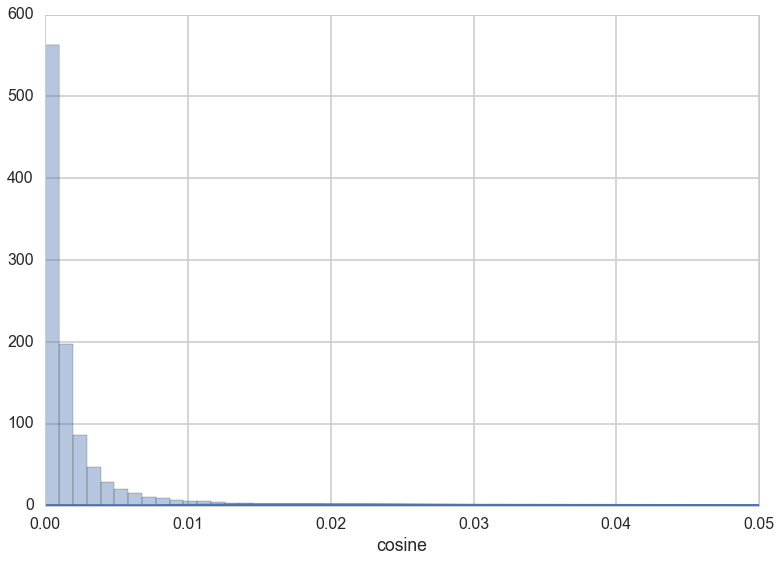

In [76]:
plt.xlim((0,.05))
sns.distplot(toplot.cosine, bins=1000)

In [77]:
# get summary stats without 1s and 0s
toplot.cosine = toplot.cosine.astype('float64')
toplot.cosine.describe()

count   161,914.00000
mean          0.00282
std           0.01274
min           0.00002
25%           0.00040
50%           0.00086
75%           0.00208
max           0.96718
Name: cosine, dtype: float64

In [78]:
print "Top Cosines:"
print toplot.sort_values("cosine", ascending=0).head(10)

print "Bottom Cosines:"
print toplot.sort_values("cosine", ascending=1).head(10)

Top Cosines:
       ticker1 ticker2  cosine
568246     BKS       B 0.96718
244346       B     BKS 0.96718
568707     BKS      NE 0.87822
608997      NE     BKS 0.87822
608587      NE       B 0.84939
244397       B      NE 0.84939
78803      CBT     COG 0.76953
390853     COG     CBT 0.76953
111036     MMM    MASI 0.75744
234276    MASI     MMM 0.75744
Bottom Cosines:
       ticker1 ticker2  cosine
450536     HPQ     GEO 0.00002
588170    EBAY     GEO 0.00002
123062     BAC     GEO 0.00002
362107     GEO      VZ 0.00002
361861     GEO    TESO 0.00002
112696      SO    TESO 0.00002
361642     GEO     BAC 0.00002
361618     GEO       V 0.00002
362056     GEO     HPQ 0.00002
362230     GEO    EBAY 0.00002


## Events

In [79]:
# get dict of concepts and articles
ticker_event_set_dict = {}
tickerslist = []
for ticker, eventinfo in ticker_events_dict.items():
    if len(eventinfo["events"]) > 0:
        if 'uriList' in eventinfo["events"]:
            ticker_event_set_dict[ticker] = set(eventinfo["events"]['uriList']['results'])
            tickerslist.append(ticker)

In [80]:
%%time
event_cosine_df = pd.DataFrame(index=tickerslist,columns=tickerslist)
i=0
for ticker_i in tickerslist:
    for ticker_j in tickerslist:
        i+=1
        event_cosine_df.loc[ticker_i, ticker_j] = (len(ticker_event_set_dict[ticker_i].intersection(ticker_event_set_dict[ticker_j])) 
                                    / np.sqrt(len(ticker_event_set_dict[ticker_i]) * len(ticker_event_set_dict[ticker_j])))
        if i % 25000 == 0:
            print i

25000
50000
75000
100000
125000
150000
175000
200000
225000
250000
275000
300000
325000
350000
375000
400000
425000
450000
475000
500000
525000
550000
575000
600000
Wall time: 2min 22s


In [81]:
# sanity check
event_cosine_df.info()
event_cosine_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 777 entries, RYN to CECO
Columns: 777 entries, RYN to CECO
dtypes: object(777)
memory usage: 4.6+ MB


,RYN,NDSN,PKY,EOG,LSTR,VSAT,CPB,NYT,SMTC,IDXX,SIG,JWN,CPT,MANT,AVAV,QLGC,VRTX,BWA,MANH,VRTU,CCOI,SPG,ENDP,GIS,VAL,AEP,ADTN,ROP,GE,GD,SRCL,VAR,BYD,JNS,MAS,MAR,MAT,SNA,LAD,CTCT,SNI,ITRI,MAC,JNJ,ODFL,SNX,CKP,TSN,SYMC,CMI,...,BRS,LEN,EBAY,BRO,MET,MDT,BRC,TWC,AZO,CPLA,REG,AZZ,PDCO,MTSC,NEWP,KELYA,MSA,TXN,DAL,HES,ORCL,DUK,TE,EAT,PXD,AA,HOG,ADI,NE,CNP,SANM,CNX,WAB,ROK,TSRA,SCI,CNL,ISRG,ESV,IPXL,DSPG,EQIX,PFG,BKH,MCS,CATO,VSH,VSI,PNRA,CECO
RYN,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00336,0.01165,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00798,0.00165,0.00270,0.00000,0.00000,0.00000,0.00000,0.00636,0.00273,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00138,0.00000,0.00175,0.00230,0.00000,0.00144,0.00455,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00135,0.00264,0.00000,0.00000,0.00000,0.01536,0.00000,0.00000,0.00000,0.00435,0.00214,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00513,0.00000
NDSN,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00283,0.00000,0.00000,0.01239,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00862,0.00000,0.00000,0.00000,0.00439,0.00000,0.00000,0.00000,0.00000,0.00000,0.01130,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
PKY,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
EOG,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00225,0.00000,0.00000,0.00000,0.00000,0.00107,0.00000,0.00000,0.00000,0.00000,0.00000,0.00380,0.00574,0.00000,0.00000,0.00000,0.00000,0.00431,0.00000,0.00000,0.00612,0.00000,0.00496,0.00181,0.00000,0.00000,0.00000,0.00218,0.00000,0.00183,0.00000,0.00000,0.00773,0.00000,0.00000,0.00000,0.00000,0.00497,0.00000,0.00000,0.00000,0.00222,0.00000,0.00000,...,0.00000,0.00000,0.00231,0.00000,0.00000,0.00154,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00264,0.00272,0.02470,0.00076,0.00392,0.00565,0.00000,0.07105,0.00121,0.00103,0.00582,0.01860,0.00000,0.00000,0.00326,0.00000,0.00000,0.00000,0.00000,0.00000,0.00350,0.00000,0.00000,0.00000,0.00000,0.00413,0.00000,0.00000,0.00000,0.00592,0.00000,0.00515,0.00000
LSTR,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00367,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00912,0.00000,0.00000,0.00000,0.0000

In [82]:
# sanity check
event_cosine_df.stack().value_counts().head(10)

0.00000    469512
1.00000       777
0.00575        20
0.00870        20
0.00901        18
0.00232        18
0.01627        16
0.00248        16
0.00225        16
0.00927        16
dtype: int64

Aright, let's get an idea as to the distributions of these cosines. We're going to exlucde 0 values, we know how man of this exist from above (aproximately one half or so, which is good!)

In [83]:
# get frame without 0s and 1s
events_cosines_stacked = event_cosine_df.stack().reset_index()
events_cosines_stacked.columns = ["ticker1","ticker2","cosine"]

toplot = events_cosines_stacked[(events_cosines_stacked.cosine != 0) & (events_cosines_stacked.cosine != 1)].copy()

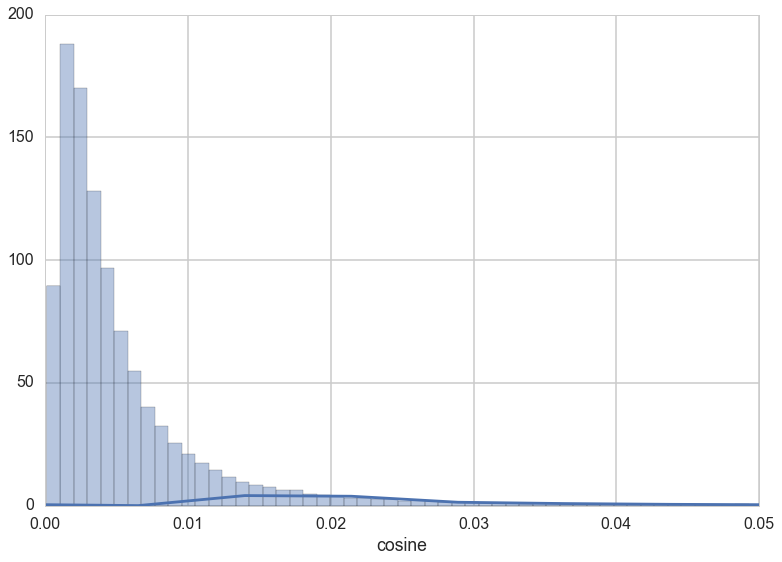

In [84]:
plt.xlim((0,.05))
sns.distplot(toplot.cosine, bins=1000)

In [85]:
# get summary stats without 1s and 0s
toplot.cosine = toplot.cosine.astype('float64')
toplot.cosine.describe()

count   133,440.00000
mean          0.00656
std           0.01564
min           0.00011
25%           0.00194
50%           0.00352
75%           0.00664
max           0.94529
Name: cosine, dtype: float64

In [86]:
print "Top Cosines:"
print toplot.sort_values("cosine", ascending=0).head(10)

print "Bottom Cosines:"
print toplot.sort_values("cosine", ascending=1).head(10)

Top Cosines:
       ticker1 ticker2  cosine
547310     BKS       B 0.94529
235358       B     BKS 0.94529
22205       GE     GEO 0.83050
348901     GEO      GE 0.83050
587339      NE     BKS 0.75148
547763     BKS      NE 0.75148
317320    XLNX      XL 0.73123
236616      XL    XLNX 0.73123
376942     COG     CBT 0.72942
75854      CBT     COG 0.72942
Bottom Cosines:
       ticker1 ticker2  cosine
83582     AMGN    NWSA 0.00011
344318    NWSA    AMGN 0.00011
290372    NFLX    TUES 0.00016
428500    TUES    NFLX 0.00016
121655     CAG    NWSA 0.00018
344367    NWSA     CAG 0.00018
452063      BA    PRAA 0.00018
486983    PRAA      BA 0.00018
73848      CBS     JNS 0.00019
25736      JNS     CBS 0.00019


# Calculating Market Correlations <a id=marketcorr></a>

In [87]:
stocksdf = financialdf
# there are some stocks with a return value of C, we remove them and convert to float
stocksdf.drop(stocksdf[stocksdf.ret == 'C'].index, inplace=1)
stocksdf.ret = stocksdf.ret.astype(float)

In [88]:
# we have some duplicates in our data set
stocksdf[stocksdf.duplicated(["date","ticker"])].ticker.value_counts()[:15]

TAP     1510
BIO     1510
GEF     1510
HVT     1510
LEN     1510
MKC     1510
CBS     1510
STZ     1510
WSO     1510
TDS      520
AAN      239
DO         9
COLB       8
CBSH       7
NAN        7
Name: ticker, dtype: int64

In [89]:
# let's check if these duplicates also have different vwretd data
stocksdf[stocksdf.duplicated(["date","ticker","ret", "sprtrn"])].shape

(147, 19)

Since they don't, we don't have to care, woohoo! 

In [90]:
# we reshape our data to get a dataframe with a date index and each ticker as a column
temp = stocksdf[["date", "sprtrn", "ticker","ret","vol"]].copy().drop_duplicates(["date","ticker"])

# add variables
temp["return_over_market"] = temp.ret - temp.sprtrn
temp["abolute_return"] = np.absolute(temp.ret - temp.sprtrn)

# get necessary unstacked dataframes
returns = temp[["date","ticker","return_over_market"]].copy().set_index(["date","ticker"]).unstack('ticker')
absreturns = temp[["date","ticker","abolute_return"]].copy().set_index(["date","ticker"]).unstack('ticker')
volumes = temp[["date","ticker","vol"]].copy().set_index(["date","ticker"]).unstack('ticker')



In [91]:
# we quickly check for null entries (not too many)
print returns.isnull().sum().sum()
print volumes.isnull().sum().sum()
print absreturns.isnull().sum().sum()

19
23
19


In [92]:
%%time
# we compute correlation matrices over the period
return_correlations = returns.corr(method='pearson')
absreturn_correlations = absreturns.corr(method='pearson')
volume_correlations = volumes.corr(method='pearson')

Wall time: 2min 55s


In [93]:
# change index
return_correlations = return_correlations.reset_index(1).reset_index(drop=True).set_index('ticker')
return_correlations.columns = return_correlations.columns.droplevel()
return_correlations.columns.name = 'ticker1'

absreturn_correlations = absreturn_correlations.reset_index(1).reset_index(drop=True).set_index('ticker')
absreturn_correlations.columns = absreturn_correlations.columns.droplevel()
absreturn_correlations.columns.name = 'ticker1'

volume_correlations = volume_correlations.reset_index(1).reset_index(drop=True).set_index('ticker')
volume_correlations.columns = volume_correlations.columns.droplevel()
volume_correlations.columns.name = 'ticker1'


# Comparing Results <a id=results></a>

## Drop duplicates & diagnol
Since this is an important step, I will include my process of figuring it out below. 

After looking at 5-6 differnet stack exchange suggestions, I start with the suggestion here:
http://stackoverflow.com/questions/34417685/melt-the-upper-triangular-matrix-of-a-pandas-dataframe

In [94]:
test = article_cosine_df.iloc[:10,:10]
test

,RYN,NDSN,PKY,EOG,LSTR,VSAT,CPB,NYT,SMTC,IDXX
RYN,1.00000,0.00000,0.00000,0.00000,0.00295,0.00000,0.00000,0.00203,0.00000,0.00000
NDSN,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
PKY,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
EOG,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00258,0.00000,0.00000,0.00000
LSTR,0.00295,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000
VSAT,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000
CPB,0.00000,0.00000,0.00000,0.00258,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
NYT,0.00203,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00372,0.00000
SMTC,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00372,1.00000,0.00000
IDXX,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000


In [95]:
test = test.where(np.triu(np.ones(test.shape)).astype(np.bool))
test

,RYN,NDSN,PKY,EOG,LSTR,VSAT,CPB,NYT,SMTC,IDXX
RYN,1.00000,0.00000,0.00000,0.00000,0.00295,0.00000,0.00000,0.00203,0.00000,0.00000
NDSN,NaN,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
PKY,NaN,NaN,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
EOG,NaN,NaN,NaN,1.00000,0.00000,0.00000,0.00258,0.00000,0.00000,0.00000
LSTR,NaN,NaN,NaN,NaN,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000
VSAT,NaN,NaN,NaN,NaN,NaN,1.00000,0.00000,0.00000,0.00000,0.00000
CPB,NaN,NaN,NaN,NaN,NaN,NaN,1.00000,0.00000,0.00000,0.00000
NYT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00000,0.00372,0.00000
SMTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00000,0.00000
IDXX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00000


We also get rid of diagnol values:

In [96]:
np.fill_diagonal(test.values, np.nan)
test.head()

,RYN,NDSN,PKY,EOG,LSTR,VSAT,CPB,NYT,SMTC,IDXX
RYN,NaN,0.00000,0.00000,0.00000,0.00295,0.00000,0.00000,0.00203,0.00000,0.00000
NDSN,NaN,NaN,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
PKY,NaN,NaN,NaN,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
EOG,NaN,NaN,NaN,NaN,0.00000,0.00000,0.00258,0.00000,0.00000,0.00000
LSTR,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,0.00000,0.00000,0.00000


Sweeeeeeet! We transform all 4 matrices:

In [97]:
stacks_dict = {}
stack_names = ["article_cosines","event_cosines", 'vol_corr', 'absret_corr']
for name, matrix in zip(stack_names, [article_cosine_df, event_cosine_df, volume_correlations, absreturn_correlations]):
    matrix = matrix.where(np.triu(np.ones(matrix.shape)).astype(np.bool))
    np.fill_diagonal(matrix.values, np.nan)
    matrix = matrix.stack().reset_index()
    matrix.columns = ["ticker1", "ticker2", name + "_values"]
    matrix[name + "_values"] = pd.to_numeric(matrix[name + "_values"])
    stacks_dict[name] = matrix

## Make sure dimensions and everything makes sense

In [98]:
for df in ["article_cosines", "event_cosines", 'vol_corr', 'absret_corr']:
    stacks_dict[df].info()
    print "\n"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312445 entries, 0 to 312444
Data columns (total 3 columns):
ticker1                   312445 non-null object
ticker2                   312445 non-null object
article_cosines_values    312445 non-null float64
dtypes: float64(1), object(2)
memory usage: 7.2+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301476 entries, 0 to 301475
Data columns (total 3 columns):
ticker1                 301476 non-null object
ticker2                 301476 non-null object
event_cosines_values    301476 non-null float64
dtypes: float64(1), object(2)
memory usage: 6.9+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 921403 entries, 0 to 921402
Data columns (total 3 columns):
ticker1            921403 non-null object
ticker2            921403 non-null object
vol_corr_values    921403 non-null float64
dtypes: float64(1), object(2)
memory usage: 21.1+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 921403 entries, 0 to 921402
Data columns

Above, there are less values for the event cosine matrix. This makes sense, since if the numerator 

In [99]:
stacks_dict["article_cosines"].merge(stacks_dict['vol_corr'], how='inner', on=["ticker1", "ticker2"]).head()

,ticker1,ticker2,article_cosines_values,vol_corr_values
0,RYN,VSAT,0.00000,0.08909
1,RYN,SMTC,0.00000,0.08329
2,RYN,SIG,0.00101,0.05358
3,RYN,VRTX,0.00000,0.01886
4,RYN,VRTS,0.00000,0.14794


## Run regressions

In [100]:
# make one dataframe
dfs = [stacks_dict['article_cosines'],stacks_dict['event_cosines'],stacks_dict['absret_corr'], stacks_dict['vol_corr']]
df_regressions = reduce(lambda left,right: pd.merge(left,right,on=["ticker1", "ticker2"]), dfs)

In [101]:
df_regressions.info()
df_regressions.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148600 entries, 0 to 148599
Data columns (total 6 columns):
ticker1                   148600 non-null object
ticker2                   148600 non-null object
article_cosines_values    148600 non-null float64
event_cosines_values      148600 non-null float64
absret_corr_values        148600 non-null float64
vol_corr_values           148600 non-null float64
dtypes: float64(4), object(2)
memory usage: 7.9+ MB


,ticker1,ticker2,article_cosines_values,event_cosines_values,absret_corr_values,vol_corr_values
0,RYN,VSAT,0.00000,0.00000,0.01492,0.08909
1,RYN,SMTC,0.00000,0.00000,0.00056,0.08329
2,RYN,SIG,0.00101,0.00000,0.05156,0.05358
3,RYN,VRTX,0.00000,0.00000,-0.00291,0.01886
4,RYN,VRTU,0.00000,0.00000,-0.00869,0.10453


In [146]:
from statsmodels.iolib.summary2 import summary_col

reg = {}
regressions_list = []
for pair in [(2,-2),(3,-2),(2,-1),(3,-1)]:
    reg[pair] = sm.OLS(df_regressions.ix[:,pair[1]],df_regressions.ix[:,pair[0]])
    reg[pair] = reg[pair].fit()
    regressions_list.append(reg[pair])
    print reg[pair].summary()


    print "\n\n"


dfoutput = summary_col(regressions_list,stars=True)
print(dfoutput)

                            OLS Regression Results                            
Dep. Variable:     absret_corr_values   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     4020.
Date:                Mon, 02 May 2016   Prob (F-statistic):               0.00
Time:                        17:05:45   Log-Likelihood:             1.8765e+05
No. Observations:              148600   AIC:                        -3.753e+05
Df Residuals:                  148599   BIC:                        -3.753e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
article_cosines_values     1

OK, so the $R^2$ is pitiful, but using events instead of news doubles it!!!

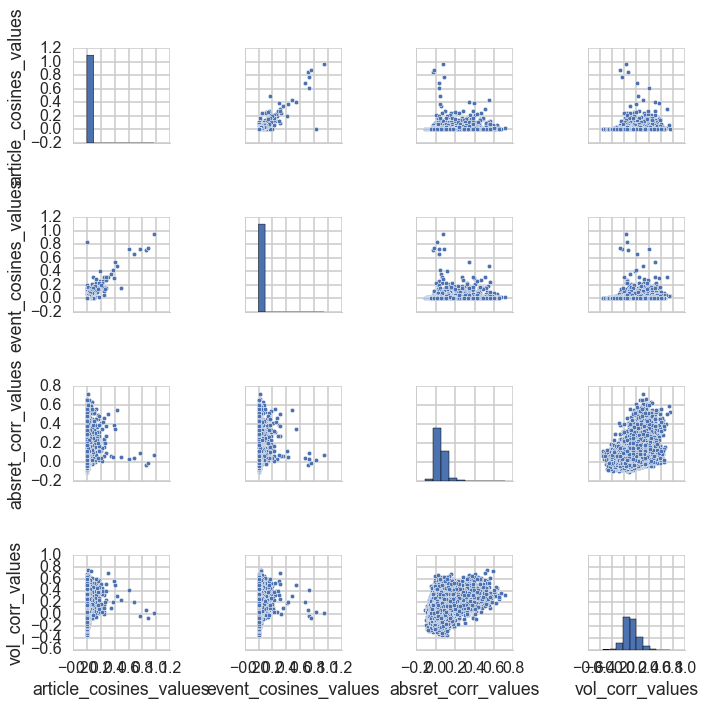

In [103]:
g = sns.pairplot(df_regressions)

In [104]:
df_regressions.to_csv('../data/regressionsdf.csv')